In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('winequality-white.csv', sep=";")
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [3]:
X = data[data.columns[:-1]].values
y = data['quality'].values

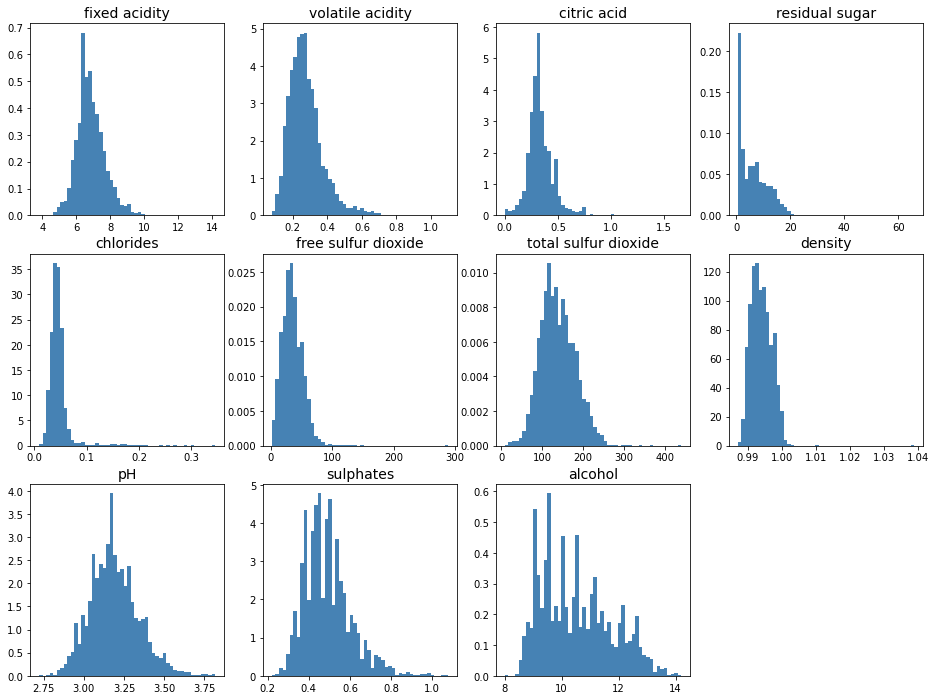

In [4]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

### Model selection

We will start by transforming this problem into a classification problem: it will be a question of separating good wines from mediocre wines:

In [5]:
y_class = np.where(y<6, 0, 1)

Let's separate our data into a training set and a test set. The test set will contain 30% of the data.

In [6]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = \
	model_selection.train_test_split(X, y_class,
                                	test_size=0.3 # 30% des données dans le jeu de test
                                	)

We can now standardize the training data and apply the same transformation to the test data:

In [7]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

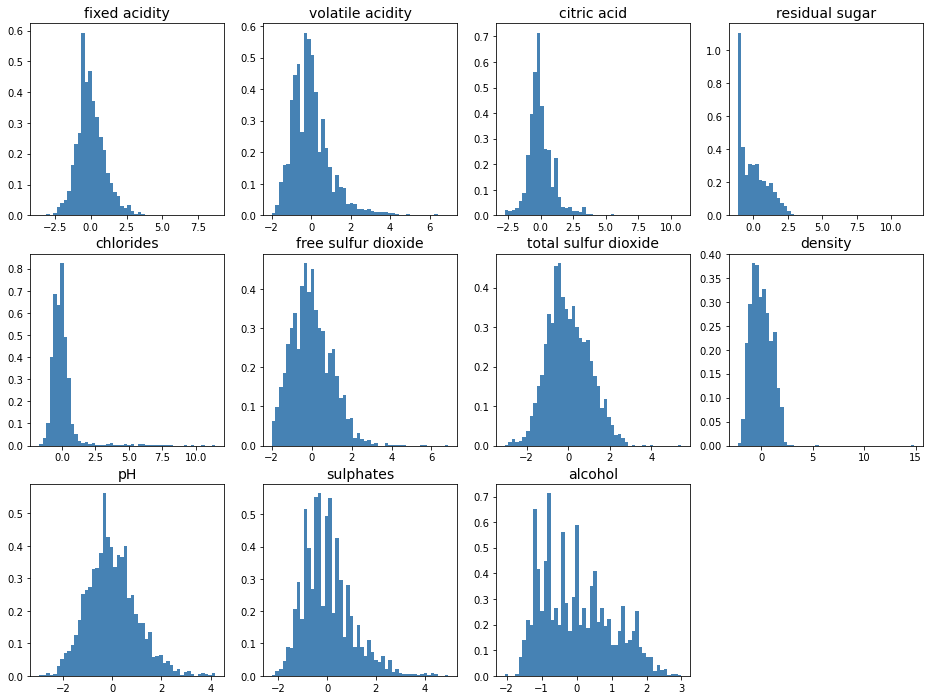

In [8]:
fig = plt.figure(figsize=(16, 12))
for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color = 'steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)


### GridSearch implementation

We will now use the "GridSearchCV" method to cross-validate the k parameter of a kNN (the number of closest neighbors) on the training set:

In [9]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Best hyperparametre in the training data:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Cross validation results:")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )


Best hyperparametre in the training data:
{'n_neighbors': 15}
Cross validation results:
accuracy = 0.749 (+/-0.014) for {'n_neighbors': 3}
accuracy = 0.758 (+/-0.024) for {'n_neighbors': 5}
accuracy = 0.754 (+/-0.023) for {'n_neighbors': 7}
accuracy = 0.753 (+/-0.020) for {'n_neighbors': 9}
accuracy = 0.759 (+/-0.035) for {'n_neighbors': 11}
accuracy = 0.760 (+/-0.041) for {'n_neighbors': 13}
accuracy = 0.761 (+/-0.037) for {'n_neighbors': 15}


The best performance (~ 0.757) is achieved here with 7 neighbors.

In [10]:
y_pred = clf.predict(X_test_std)
print("\nIn the test set: {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))


In the test set: 0.779


We can now look at the performance on the test set. GridSearchCV automatically retrained the best model over the entire training set.